# Atividade 5

Aluno: Raul Procópio Mota

Matrícula: 102100648

# Entrada de dados

Lê e processa os dados do deck do Newave

In [28]:
import os
from PySDDP.Pen import Newave

Caminho_do_Arquivo = os.getcwd() + '/NewaveAgo2023/'

PMO = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


# Modelagem do problema

$$Min \hspace{0.5cm} \sum_{ano=1931}^{2021}\varepsilon_{ago,ano}^2$$

Sujeito a:

$$Z_{ago,1931} = \phi_1 \cdot Z_{jul,1931} + \phi_2 \cdot Z_{jun,1931} + ... +  \phi_n \cdot Z_{n,1931}  + \varepsilon_{ago,1931}^2  $$

$$Z_{ago,1932} = \phi_1 \cdot Z_{jul,1932} + \phi_2 \cdot Z_{jun,1932} + ... +  \phi_n \cdot Z_{n,1932}  + \varepsilon_{ago,1932}^2  $$

$$.$$

$$.$$

$$.$$

$$Z_{ago,2021} = \phi_1 \cdot Z_{jul,2021} + \phi_2 \cdot Z_{jun,2021} + ... +  \phi_n \cdot Z_{n,2021}  + \varepsilon_{ago,2021}^2  $$

In [29]:
import numpy as np
from cvxopt import solvers, matrix

def otimiza_coeficientes(nome_usina, ordem, mes):

    # Obtem os dados da usina
    usina = PMO.confhd.get(nome_usina)

    # Valida a usina
    if usina is None:
        raise Exception('Usina não encontrada. Por favor, verifique o nome da mesma.')
    
    # Valida a ordem
    if not(1 <= ordem <= 11):
        raise Exception('A ordem do modelo deve estar entre 1 e 11 meses.')
    
    # Valida o mes
    if not(0 <= mes <= 11):
        raise Exception('O mês selecionado deve estar entre 0 e 11 (Jan-Dez)')

    # Obtem as vazões naturais afluentes da usina retirando os dois últimos anos
    VNA = usina['vazoes']


    # Cria os parâmetros que compõe o problma quadrático
    P = matrix(cria_matriz_quadratica_fob(VNA, ordem, mes).astype('float'))
    q = matrix(cria_vetor_linear_fob(VNA, ordem, mes).astype('float'))
    G = matrix(cria_matriz_coef_restricoes_desigualdade(VNA, ordem, mes).astype('float'))
    h = matrix(cria_vetor_valores_restricoes_desigualdade(VNA, ordem, mes).astype('float'))
    A = matrix(cria_matriz_coef_restricoes_igualdade(VNA, ordem, mes).astype('float'))
    b = matrix(cria_vetor_valores_restricoes_igualdade(VNA, ordem, mes).astype('float'))

    # Realiza o tratamento de parâmetros vazios
    if not(len(P)): P = None
    if not(len(q)): q = None
    if not(len(G)): G = None
    if not(len(h)): h = None
    if not(len(A)): A = None
    if not(len(b)): b = None

    # Define as tolerâncias de convergência
    abstol = 1e-9
    reltol = 1e-9
    
    # Soluciona o problema quadrático
    sol = solvers.qp(P, q, G, h, A, b, solver='glpk', abstol=abstol, reltol=reltol)

    result = {
        "phi": np.array(sol['x'][:ordem]),
        "erros": np.array(sol['x'][ordem:])
    }

    return result

def cria_matriz_quadratica_fob(VNA, ordem, mes):
    # Obtem o número de anos e número de meses presentes na VNA
    num_ano, num_mes = np.shape(VNA)

    # Caso o mês seja menor que a ordem do modelo, o dados do primeiro ano do histórico serão ignorados
    if (mes < ordem):
        num_ano -= 1

    # Criar a matriz diagonal que representa a matriz quadrática da fob
    matriz = np.diag(np.concatenate((np.zeros(ordem), 2*np.ones(num_ano)), axis=0))

    return matriz

def cria_vetor_linear_fob(VNA, ordem, mes):
    # Obtem o número de anos e número de meses presentes na VNA
    num_ano, num_mes = np.shape(VNA)

    # Caso o mês seja menor que a ordem do modelo, o dados do primeiro ano do histórico serão ignorados
    if (mes < ordem):
        num_ano -= 1

    # Criar a vetor que representa os custos lineares da fob
    vetor = np.zeros(ordem + num_ano)

    return vetor

def cria_matriz_coef_restricoes_desigualdade(VNA, ordem, mes):
    # Não existem restrições de desigualdade
    matriz = np.array([])

    return matriz

def cria_vetor_valores_restricoes_desigualdade(VNA, ordem, mes):
    # Não existem restrições de desigualdade
    vetor = np.array([])

    return vetor

def cria_matriz_coef_restricoes_igualdade(VNA, ordem, mes):
    
    # Transforma a matriz de vazões em um vetor
    VNA_achatada = VNA.flatten()
    
    # Divide a matriz achatada de forma que o primeiro valor seja referente ao mês de interesse 
    # e o último valor seja referente ao mês anterior ao de interesse
    primeira_linha, matriz_achatada, ultima_linha = np.split(VNA_achatada, [mes, mes-12])

    # Caso o mês seja maior ou igual à ordem do modelo, os dados da primeira linha são incorporados 
    # à matriz de coeficientes achatada 
    if (mes >= ordem):
        # Primeira linha completada com zeros à esquerda (total de itens = 12)
        primeira_linha = np.concatenate((np.zeros(12-mes), primeira_linha))

        # Junção da primeira linha à matriz de coeficientes achatada
        matriz_achatada = np.concatenate((primeira_linha, matriz_achatada), axis=0)

    # Define o formato da matriz de conficientes de restrições de igualdade reconfigurada (dimensão num_ano x num_mes)
    num_mes = 12
    num_anos = np.size(matriz_achatada)//num_mes

    # Cria a matriz apenas com os meses necessários para o modelo
    matriz = np.reshape(matriz_achatada, (num_anos, num_mes))[:,-ordem:]

    # Concatena à matriz os erros de cada equação representados pela matrix identidade
    matriz = np.concatenate((matriz, np.eye(num_anos)), axis=1)

    return matriz

def cria_vetor_valores_restricoes_igualdade(VNA, ordem, mes):
    # Define a linha inicial da aquisição de dados
    num_primeira_linha = 0

    # Caso o mês seja menor que a ordem do modelo, o dados do primeiro ano do histórico serão ignorados
    if (mes < ordem):
        num_primeira_linha += 1

    # # Criar a vetor que representa os valores das equações de igualdade 
    vetor = VNA[num_primeira_linha:, mes]
        
    return vetor

## Funções de criação de dados

In [39]:
def calcula_vazao(nome_usina, ordem, mes, ano, phi):

    # Obtem os dados da usina
    usina = PMO.confhd.get(nome_usina)

    # Valida a usina
    if usina is None:
        raise Exception('Usina não encontrada. Por favor, verifique o nome da mesma.')
    
    # Valida a usina
    if ordem != len(phi):
        raise Exception('O número de coeficientes do modelo de regressão é diferente da ordem.')
    
    # Vazão natural afluente
    VNA = usina['vazoes'][:-2]

    num_anos, num_mes = np.shape(VNA)
    
    if (ano-1931 >= num_anos) or (ano < 1931):
        raise Exception('O ano selecionado não possui histórico que possibilite a estimação da vazão (Min: 1931, Max: ' + str(1931+num_anos-1) + ').')

    vazao_real = VNA[ano-1931, mes]

    if (mes < ordem):
        if (ano < 1932):
            raise Exception('Não existem dados para estimar a vazão na data ' + str(mes+1) + '/' + str(ano) + '.')
        else:
            vazao_estimada = np.dot(VNA[ano-1932, mes-ordem:], phi[:ordem-mes])
            vazao_estimada += np.dot(VNA[ano-1931, :mes], phi[ordem-mes:])
    else:
        vazao_estimada = np.dot(VNA[ano-1931, mes-ordem:mes], phi)
        
    vazao_estimada = vazao_estimada
    erro = vazao_real - vazao_estimada

    return {
        'vazao_real': vazao_real,
        'vazao_estimada': vazao_estimada,
        'erro': erro
    }

def cria_serie_sintetica(nome_usina, ordem, phi, ano_ini, ano_fim):
    # Obtem os dados da usina
    usina = PMO.confhd.get(nome_usina)

    # Valida a usina
    if usina is None:
        raise Exception('Usina não encontrada. Por favor, verifique o nome da mesma.')

    phi_linhas, phi_colunas, null = np.shape(phi)

    if ordem != phi_colunas:
        raise Exception('O número de coeficientes do modelo de regressão é diferente da ordem.')
    
    # Vazão natural afluente
    VNA = usina['vazoes'][:-2]

    num_anos, num_mes = np.shape(VNA)

    if (ano_ini > ano_fim):
        raise Exception('O ano final deve ser maior que a data inicial.')
    
    if (ano_ini < 1932):
        raise Exception('O ano inicial deve ser maior que o ano de 1931.')
    
    lista_vazoes_estimadas = []
    
    if (ano_ini > 1931+num_anos-1):
        lista_vazoes_estimadas = list(VNA[-1,-ordem:])
    else:
        lista_vazoes_estimadas = list(VNA[ano_ini-1931-1,-ordem:])

    for ano in np.arange(np.min((ano_ini, 1931+num_anos)), ano_fim+1, 1):
        for mes in range(12):
            vazao_estimada = np.dot(lista_vazoes_estimadas[-ordem:], phi[mes])[0]

            lista_vazoes_estimadas.append(vazao_estimada)

    return np.reshape(lista_vazoes_estimadas[-(ano_fim-ano_ini+1)*12:], (ano_fim-ano_ini+1, 12))

# Programa principal

In [31]:
import numpy as np

Nome_Usina = 'Furnas'


resultado = {}

for ordem in np.arange(1,12,1):
    phi = []
    erros = []

    for mes in range(12):
        otimizacao = otimiza_coeficientes(Nome_Usina, ordem, mes)

        phi.append(otimizacao['phi'])
        erros.append(otimizacao['erros'])

    resultado['ordem_' + str(ordem)] = {'phi': phi, 'erros': erros}



# Obtem os dados da usina
usina = PMO.confhd.get(Nome_Usina)

# Valida a usina
if usina is None:
    raise Exception('Usina não encontrada. Por favor, verifique o nome da mesma.')

# Vazões reais
vezoes_reais = usina['vazoes']



vazoes_estimadas = []
erros = []
for ordem in np.arange(1,12,1):
    vazoes_estimadas_ano = []
    erros_ano = []
        
    for ano in np.arange(1931,2021+1,1):
        vazoes_estimada_mes = []
        erros_mes = []

        for mes in range(12):
            if (ano > 1931):
                phi = resultado['ordem_' + str(ordem)]['phi'][mes]

                resultado_vazao = calcula_vazao(Nome_Usina, ordem, mes, ano, phi)

                vazoes_estimada_mes.append(resultado_vazao['vazao_estimada'])
                erros_mes.append(resultado_vazao['erro'])
            else:
                vazoes_estimada_mes.append(0)
                erros_mes.append(0)
            
        vazoes_estimadas_ano.append(vazoes_estimada_mes)
        erros_ano.append(erros_mes)

    vazoes_estimadas.append(vazoes_estimadas_ano)
    erros.append(erros_ano)



maiores_erros_ordem = []
erros_medios_ordem = []

for i_ordem, erros_ordem in enumerate(erros):
    maiores_erros_anuais = np.zeros(12)
    erros_acumulados_anuais = np.zeros(12)

    for i,erros_anuais in enumerate(erros_ordem):
        if (i > 0):
            maiores_erros_anuais = np.maximum(np.abs(erros_anuais)[:,0], maiores_erros_anuais)
            erros_acumulados_anuais += np.abs(erros_anuais)[:,0]

    maiores_erros_ordem.append(maiores_erros_anuais)
    erros_medios_ordem.append(erros_acumulados_anuais/(i+1))


# vazoes_atuais_estimadas = cria_serie_sintetica(Nome_Usina, 11, resultado['ordem_11']['phi'], 1932, 2025)



## Plota gráfico das vazões reais

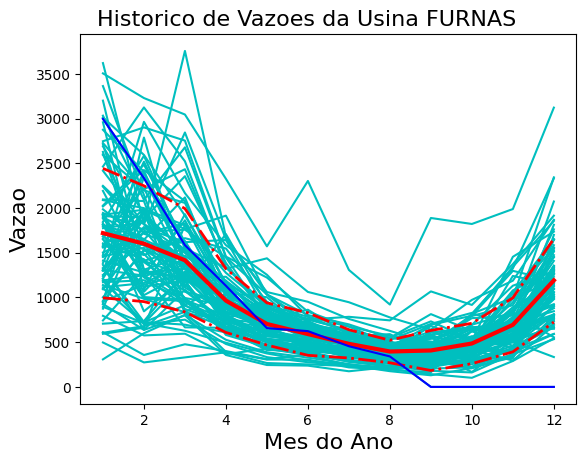

In [32]:
PMO.confhd.plot_vaz(usina)

## Plota gráfico de vazões estimadas


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


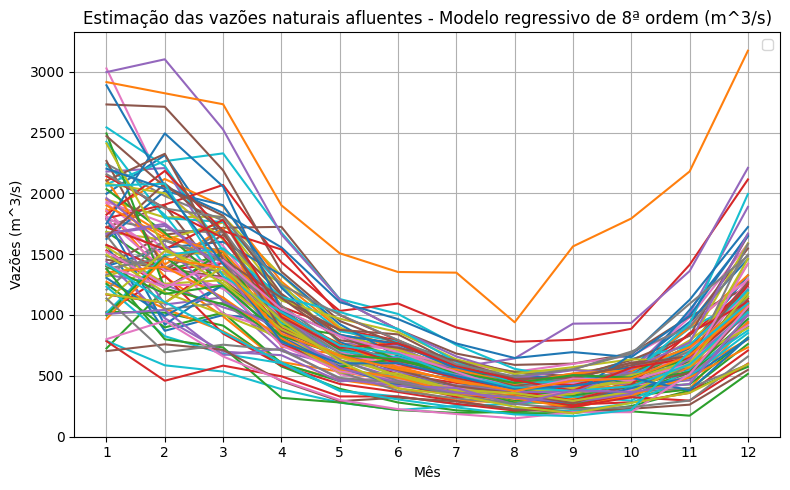

In [33]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

mes_plot = np.arange(1,13,1)
ordem = 7

for i,vazoes_estimadas_anuais in enumerate(vazoes_estimadas[ordem+1]):
    if (i > 0):
        plt.plot(mes_plot, vazoes_estimadas_anuais)

plt.title('Estimação das vazões naturais afluentes - Modelo regressivo de ' + str(ordem+1) + 'ª ordem (m^3/s)')
plt.xlabel('Mês')
plt.ylabel('Vazões (m^3/s)')

plt.legend()

plt.xticks(mes_plot)
plt.grid()
plt.tight_layout()
plt.show()

## Plota gráfico de erro de uma ordem do modelo de regressão

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


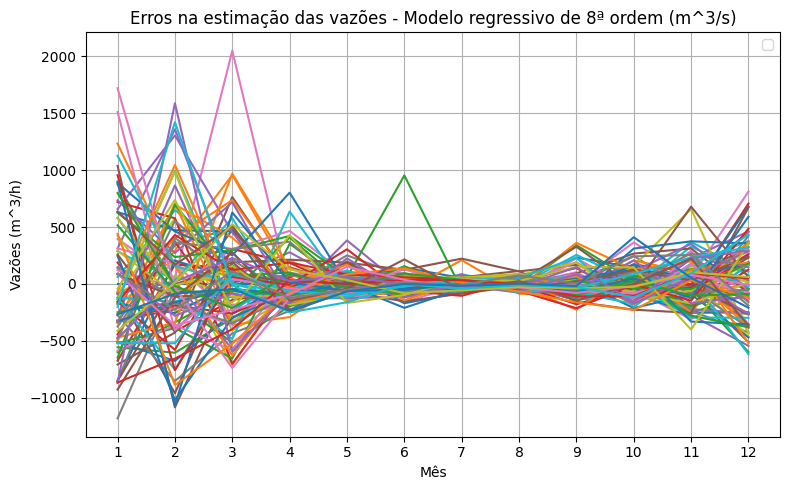

In [34]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

mes_plot = np.arange(1,13,1)
ordem = 7

for erros_anuais in erros[7]:
    if (i > 0):
        plt.plot(mes_plot, erros_anuais)


plt.title('Erros na estimação das vazões - Modelo regressivo de ' + str(ordem+1) + 'ª ordem (m^3/s)')
plt.xlabel('Mês')
plt.ylabel('Vazões (m^3/h)')

plt.legend()

plt.xticks(mes_plot)
plt.grid()
plt.tight_layout()
plt.show()

## Plota gráfico de maiores erros por ordem do modelo de regressão

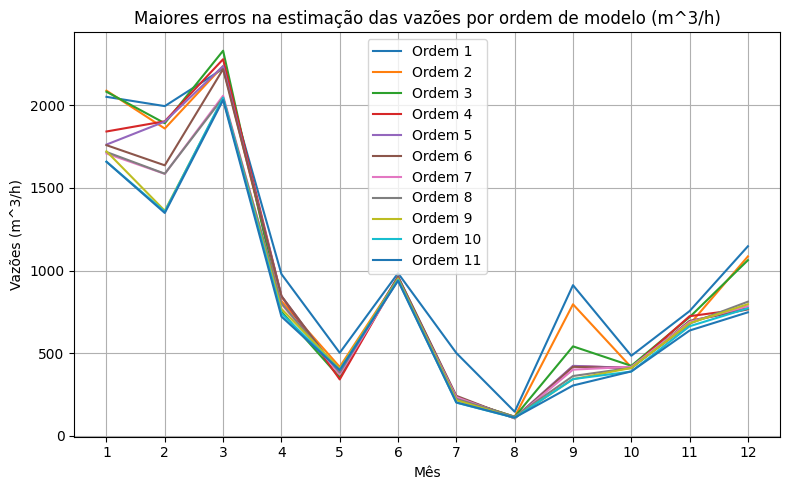

In [35]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

mes_plot = np.arange(1,13,1)

for ordem,maiores_erros in enumerate(maiores_erros_ordem):
    plt.plot(mes_plot, maiores_erros, label="Ordem " + str(ordem+1))


plt.title('Maiores erros na estimação das vazões por ordem de modelo (m^3/h)')
plt.xlabel('Mês')
plt.ylabel('Vazões (m^3/h)')

plt.legend()

plt.xticks(mes_plot)
plt.grid()
plt.tight_layout()
plt.show()

## 

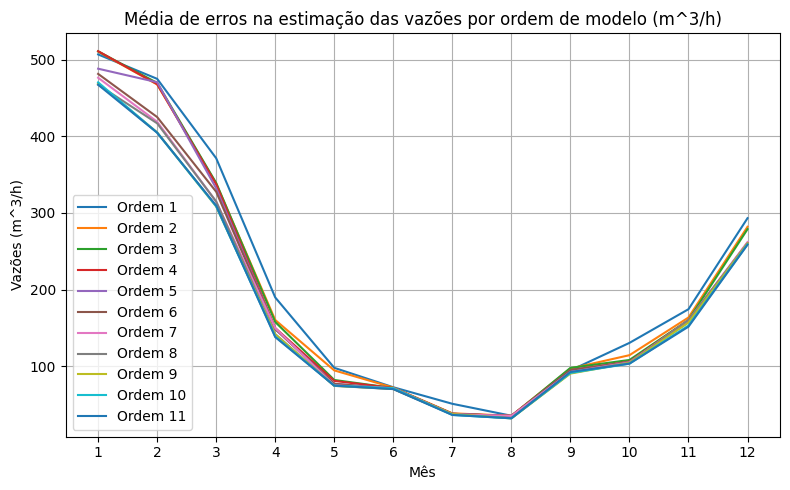

In [37]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

mes_plot = np.arange(1,13,1)

for ordem,erros_medios in enumerate(erros_medios_ordem):
    plt.plot(mes_plot, erros_medios, label="Ordem " + str(ordem+1))


plt.title('Média de erros na estimação das vazões por ordem de modelo (m^3/h)')
plt.xlabel('Mês')
plt.ylabel('Vazões (m^3/h)')

plt.legend()

plt.xticks(mes_plot)
plt.grid()
plt.tight_layout()
plt.show()